<a href="https://colab.research.google.com/github/amitkag85/CKAD-exercises/blob/master/5__Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers Overview

Since 2017, the deep learning world has been taken by storm with the advent of the Transformer. First proposed in the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) by researchers at Google Brain (but really in [Using Fast Weights to Attend to the Recent Past](https://arxiv.org/abs/1610.06258), and really really in [1991 by Jürgen Schmidhuber](https://people.idsia.ch/~juergen/fast-weight-programmer-1991-transformer.html)), the Transformer has basically become state of the art in most things. Most notibly with models like [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), the [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer) series, Vision Transformer ([ViT](https://arxiv.org/abs/2010.11929)), among others.

The main thing to know about transformers is that they operate on **sets**. Often you hear about them being used on sequences, which requires applying [positional encoding](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/) to the input. They also have a **fixed** input size, making them less flexible compared to RNNs, however due to the attention mechanism they are able to pass information between *any* part of the input to any other part, rather than being forced to only propegate information forward through the sequence.

Here we are working through how the Transformer architecture works based on the original paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) from Google Brain in 2017. We are mainly concerned with the motivation for the paper, as stated in the abstract, and the main diagrams.

In [ ]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Each input token is represented as a vector of some dimension. Here we will choose 128 but it can be anything. Also for demonstration purposes, we will choose an input length (`num`) or 10. In practice this is variable and is determined bythe current input.

In [ ]:
data = {'key': 'value'}
query = 'key'
value = data[query]
print(value)

In [ ]:
num = 10
dim = 5

Attention is based on three versions of the input:

* queries (`q`)
* keys (`k`)
* values (`v`)

For now, we will create random tensors representing each of these.


In [ ]:
q = torch.randn(num, dim)
k = torch.randn(num, dim)
v = torch.randn(num, dim)

## The Attention Operation

The first step for attention is to compute the inner product (a.k.a. scaled dot product) of the query (`q`) and key (`k`) tensors. This computes the simlarity between queries and keys, which we will then use to determine how much information should be aggregated from other tokens into each token in the next step. After computing the inner product (and scaling, which we are omitting here), we `softmax` the result, turning it into a probability distribution.

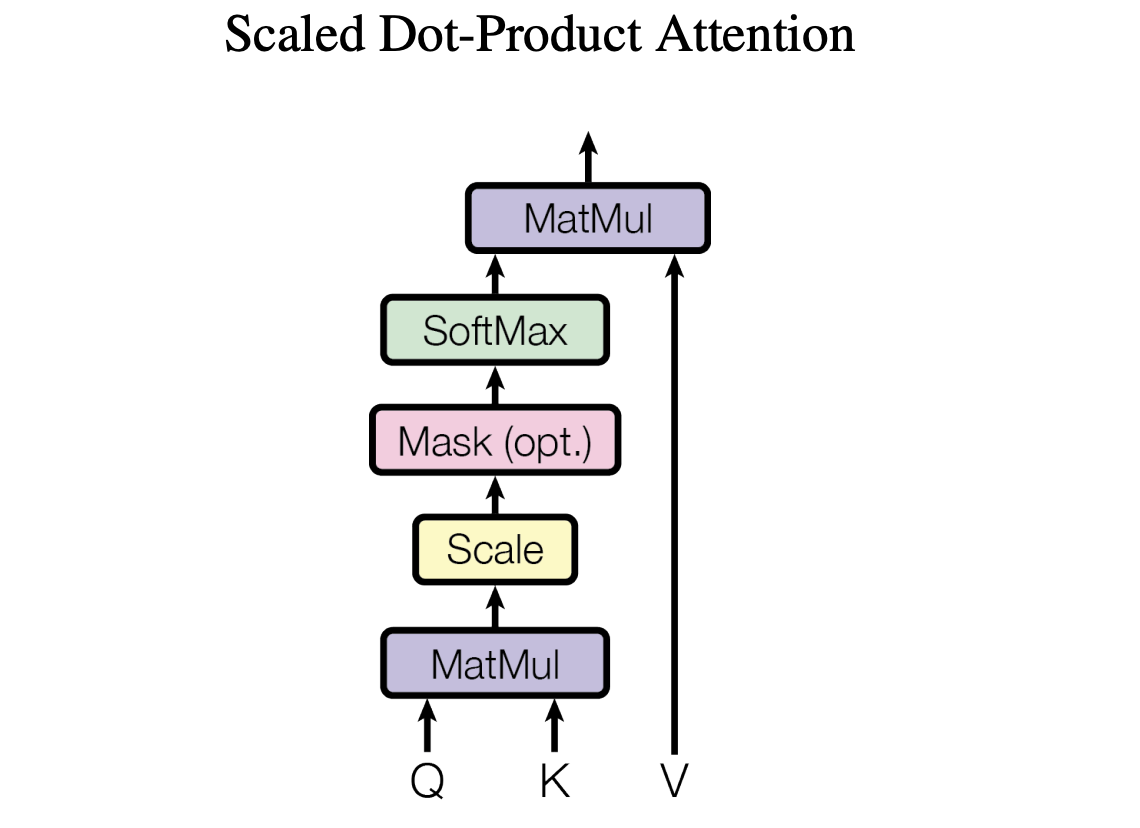

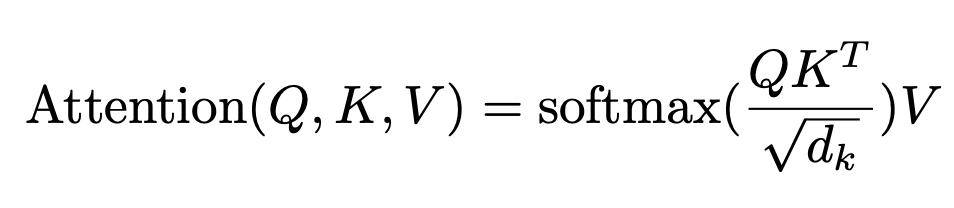

In [ ]:
print('q.size()', q.size())
print('k.size()', k.size())
qk = (q @ k.t()).softmax(dim=-1)
print(qk.size())

To prove that the result is now a probability distribution, we can see that summing along the dimension we `softmax`ed results in `1.0`.

In [ ]:
print(qk.sum(dim=-1))

We can also look at the resulting attention matrix.

In [ ]:
plt.matshow(qk)
plt.colorbar()

Finally, we can multiply the values by the attention matrix, which aggregates information from the tokens we are paying attention to into ourselves. The result is a tensor of the same dimension that we started with `(num_tokes, token_dim)` where each token has aggregated information from other parts of the input into itself.

In [ ]:
qkv = qk @ v
print(v.size())

In [ ]:
plt.matshow(v)

In [ ]:
plt.matshow(qkv)

In [ ]:
q = torch.randn(1, num, dim)
k = torch.randn(1, num, dim)
v = torch.randn(1, num, dim)

In [ ]:
def scaled_dot_product_attention(q, k, v):
  # NOTE: missing mask
  scale = math.sqrt(k.size(-1))
  qk = (q @ k.permute(0, 2, 1) / scale).softmax(dim=-1)
  return qk @ v

In [ ]:
out = scaled_dot_product_attention(q, k, v)
print(out.size())

## Attention Heads

Beyond the attention operation itself, there is other work that needs to be done. Until now we have assumed that we will be provided with `q`, `k`, and `v`. However, these actually need to be created from our inputs. To do so, we use separate `Linear` layers to project the inputs into their appropriate role. This is called an **attention head**.

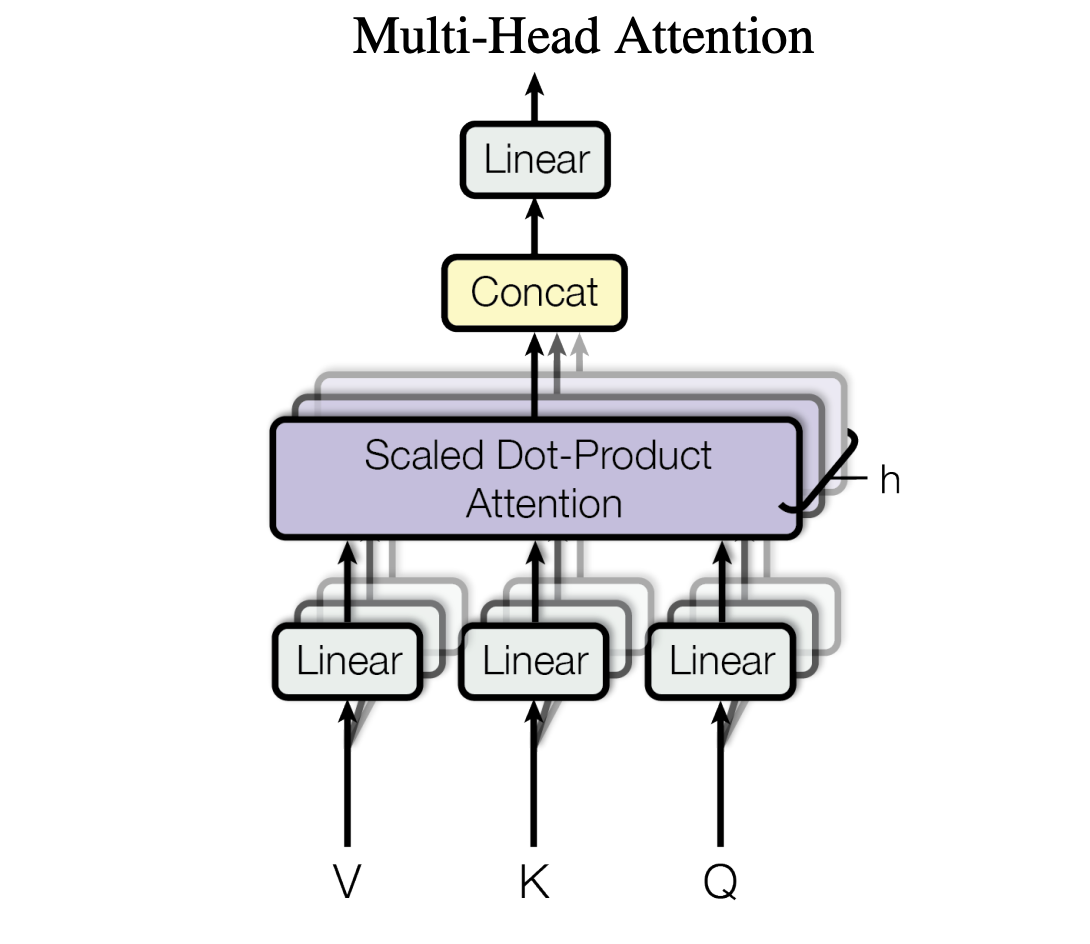

In [ ]:
class AttentionHead(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()

    self.qw = nn.Linear(in_dim, out_dim)
    self.kw = nn.Linear(in_dim, out_dim)
    self.vw = nn.Linear(in_dim, out_dim)

  def forward(self, q, k, v):
    q = self.qw(q)
    k = self.kw(k)
    v = self.vw(v)
    return scaled_dot_product_attention(q, k, v)

In [ ]:
attn = AttentionHead(dim, dim)
out = attn(v, v, v)
print(out.size())

In [ ]:
x = v[:1]
print(x)
print(x.size())

x_q = attn.qw(x)
print(x_q)
x_k = attn.kw(x)
print(x_k)

In [ ]:
attn_2 = AttentionHead(dim, dim)

In [ ]:
print(attn(x, x, x))
print(attn_2(x, x, x))

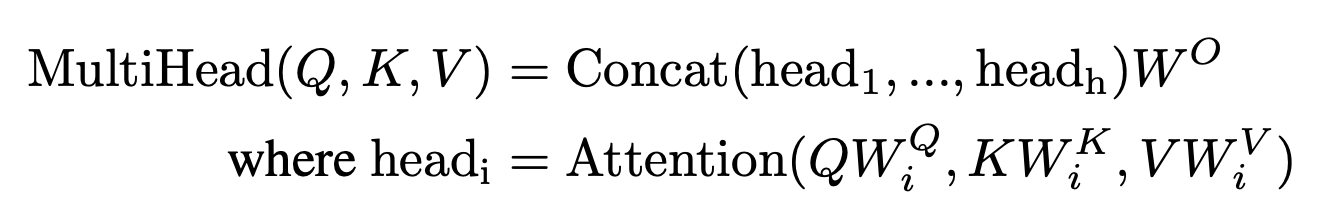

The paper illustrates what they call **multi-head attention**, which is a stack of `AttentionHead`s all running in parallel on the same inputs. This is similar to the concept of `channels` in convolutional layers: each head learns to extract its own features.

Since each head processes a copy of the input, we end up with `num_heads` more outputs. In order to pass this to the next layer, the outputs are concatenated together and projected back to their original dimension using another `Linear` layer.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, in_dim, out_dim, num_heads):
    super().__init__()

    self.heads = nn.ModuleList([])

    for _ in range(num_heads):
      self.heads.append(AttentionHead(in_dim, out_dim))

    self.out_projection = nn.Linear(out_dim * num_heads, out_dim)

  def forward(self, q, k, v):
    out = []

    for head in self.heads:
      out.append(head(q, k, v))

    h = torch.concat(out, dim=-1)

    return self.out_projection(h)

In [ ]:
mha = MultiHeadAttention(dim, dim, 3)
print(mha)

In [ ]:
out = mha(q, k, v)
print(out.size())

In [ ]:
x = torch.concat((q, q, q), dim=-1)
print(x.size())

In [ ]:
q = torch.randn(1, 5, 10)
k = torch.randn(1, 20, 10)

print((q @ k.permute(0, 2, 1)).size())

In [ ]:
out = scaled_dot_product_attention(k, q, q)
print(out.size())

In [ ]:
print(ord('a'))

## Transformer Block


### Self Attention

Remembering that

* `queries` represent what information a token is interested in
* `keys` represent what information a token has
* `values` are the actual information

If we create `q`, `k`, and `v` all from the same input we refer to that as **self attention**. This is what models like GPT use.

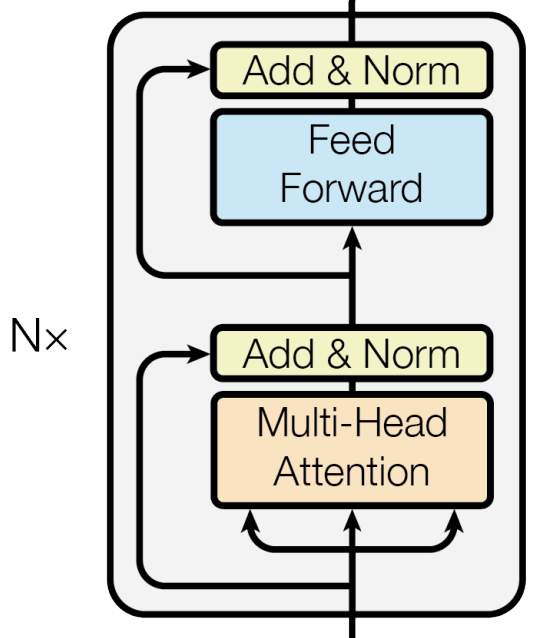

### Cross Attention

It is also possible to produce our `queries` from one input and our `keys` and `values` from a different one. This is called **cross attention**. Encoder/decoder models and multimodal models use cross attention.

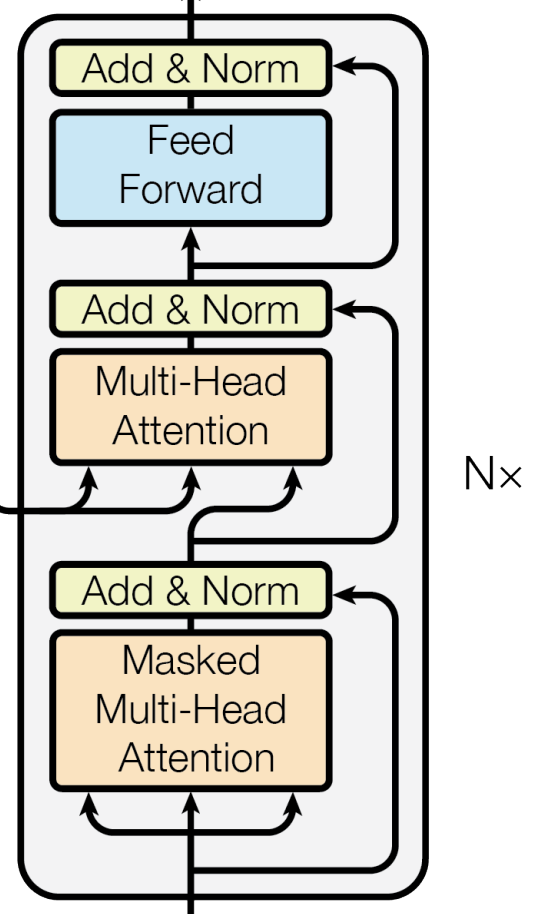

## Feed Forward Network



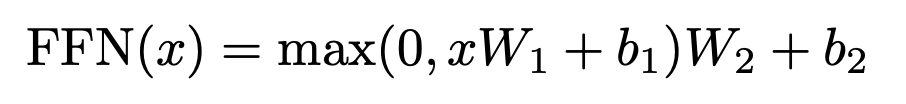

In [ ]:
class FFN(nn.Module):
  def __init__(self, in_dim, h_dim, out_dim):
    super().__init__()

    self.fc = nn.Sequential(
        nn.Linear(in_dim, h_dim),
        nn.ReLU(),
        nn.Linear(h_dim, out_dim)
    )

  def forward(self, x):
    return self.fc(x)

In [ ]:
ffn = FFN(dim, 64, dim)
print(ffn)

In [ ]:
q = torch.randn(10, dim)
print(ffn(q).size())

## Add and Normalize

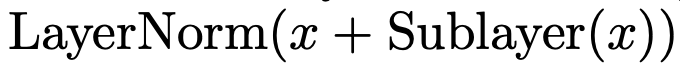

In [ ]:
class AddAndNorm(nn.Module):
  def __init__(self, dim, sub_layer):
    super().__init__()

    self.sub_layer = sub_layer
    self.norm = nn.LayerNorm(dim)

  def forward(self, x):
    return self.norm(x + self.sub_layer(x))

In [ ]:
norm = AddAndNorm(dim, ffn)
print(norm(q).size())
print(norm)

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, in_dim, out_dim, hidden_dim, num_heads):
    super().__init__()

    self.mha = MultiHeadAttention(in_dim, out_dim, num_heads)
    self.norm1 = nn.LayerNorm(out_dim)
    self.ffn = FFN(out_dim, hidden_dim, out_dim)
    self.norm2 = nn.LayerNorm(out_dim)

  def forward(self, x):
    a = self.mha(x, x, x)
    y = self.norm1(x + a)
    h = self.ffn(y)
    return self.norm2(y + h)

In [ ]:
layer = TransformerEncoderLayer(dim, dim, 128, 3)
print(layer)

In [ ]:
x = torch.randn(1, 10, dim)
print(layer(x).size())

In [ ]:
model = nn.Sequential(
    TransformerEncoderLayer(dim, dim, 128, 3),
    TransformerEncoderLayer(dim, dim, 128, 3)
)

In [ ]:
print(model)

In [ ]:
print(model(x).size())

In [ ]:
class GPT(nn.Module):
  def __init__(self, vocab_size, max_context_length, in_dim, num_heads, hidden_dim, num_layers):
    super().__init__()

    self.embeddings = nn.Embedding(vocab_size, in_dim)
    self.pos_embeddings = nn.Embedding(max_context_length, in_dim)

    transformer_layers = []
    for _ in range(num_layers):
      transformer_layers.append(TransformerEncoderLayer(in_dim,
                                                        in_dim,
                                                        hidden_dim,
                                                        num_heads))
    self.transformer_layers = nn.Sequential(*transformer_layers)

    self.output_layer = nn.Linear(in_dim, vocab_size, bias=False)

  def forward(self, x):
    embeddings = self.embeddings(x)
    # print('embeddings', embeddings.size(), embeddings)

    idx = torch.arange(embeddings.size(1)).to(x.device)
    pos = self.pos_embeddings(idx).unsqueeze(0)
    # print('pos_embeddings', pos.size(), pos)

    hidden = embeddings + pos
    # print('hidden', hidden.size(), hidden)

    # for layer in self.transformer_layers:
    #   hidden = layer(hidden)
    hidden = self.transformer_layers(hidden)

    # print('hidden', hidden.size(), hidden)

    output = self.output_layer(hidden).softmax(dim=-1)
    return output

In [ ]:
gpt = GPT(20, 10, 2, 2, 3, 2)
gpt

In [ ]:
x = torch.LongTensor([[5, 3, 7, 2, 10],
                      [6, 1, 4, 8, 7]])

In [ ]:
outputs = gpt(x)
outputs.size()

In [ ]:
outputs[:, -1].size()

In [ ]:
from torch.distributions import Categorical

In [ ]:
dist = Categorical(probs=outputs[:, -1])
y = dist.sample()
y

In [ ]:
x = torch.concat((x, y.unsqueeze(1)), dim=1)

In [ ]:
x